In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import glob
import random
import os
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from  keras.layers import  Dense, Conv2D, MaxPooling2D, Flatten,Dropout
from  tensorflow.keras import Input

In [3]:
input_image = Input(shape=(100, 100, 3))

In [4]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu'
                     ,input_shape=(100, 100, 3),padding='same'
                     )
              )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [5]:
df = pd.read_csv('data/all_data_info.csv')
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


In [6]:
dataset_paths = glob.glob("./data/train/*.jpg")


In [7]:
df['impath'] = df.new_filename.map(lambda x : f'./data/train/{x}' if f'./data/train/{x}' in dataset_paths else '' )


In [8]:
df=df[df['impath']!='']

In [50]:
df_samp = df.sample(2000)

In [51]:
df_samp['image'] = df_samp.new_filename.map(lambda x :np.array(Image.open(f'./data/train/{x}').resize((100,100))))

In [52]:
df_samp['image_shape'] = df_samp.image.map(lambda x : x.shape )
df_samp= df_samp[df_samp['image_shape']==(100, 100, 3)]

In [53]:
df_samp['image_shape'].value_counts()

(100, 100, 3)    1973
Name: image_shape, dtype: int64

In [54]:
batch_size = 16
train_input_shape = (224, 224, 3)

In [55]:
X= df_samp.image
y=df_samp['artist']

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
np.shape(X_train)

(1479,)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [60]:
X_train = np.array(list(X_train))

In [64]:
def initialize_model():
    
    # $CHALLENGIFY_BEGIN
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(709, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    
    # $CHALLENGIFY_END    
    
    return model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(np.asarray(y_train.factorize()[0]))

In [65]:
model = initialize_model()
model.fit(np.array(X_train)/255, y_train,epochs=50,callbacks=[es],verbose=1,batch_size=32, validation_split=0.2)

Epoch 1/50
37/37 [==============================] - 3s 65ms/step - loss: 6.5855 - accuracy: 8.4531e-04 - val_loss: 6.5659 - val_accuracy: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 2s 57ms/step - loss: 6.5252 - accuracy: 0.0051 - val_loss: 6.5759 - val_accuracy: 0.0101
Epoch 3/50
37/37 [==============================] - 2s 56ms/step - loss: 6.4471 - accuracy: 0.0042 - val_loss: 6.6067 - val_accuracy: 0.0034
Epoch 4/50
37/37 [==============================] - 2s 56ms/step - loss: 6.3838 - accuracy: 0.0085 - val_loss: 6.6776 - val_accuracy: 0.0068
Epoch 5/50
37/37 [==============================] - 2s 56ms/step - loss: 6.3290 - accuracy: 0.0059 - val_loss: 6.7411 - val_accuracy: 0.0000e+00


In [ ]:
test=np.array([np.array(Image.open('./data/train/1541.jpg').resize((100,100)))])

In [ ]:
model.predict(test)


1/1 [==============================] - 0s 64ms/step


array([[0.0022264 , 0.00221044, 0.00223365, 0.00221113, 0.0022467 ,
        0.00221189, 0.00220132, 0.00222751, 0.00220606, 0.00222969,
        0.00221694, 0.00222416, 0.0022346 , 0.00223442, 0.00222689,
        0.00219716, 0.00219623, 0.00224436, 0.0022116 , 0.00221648,
        0.00223857, 0.00223644, 0.00221531, 0.0022148 , 0.00224107,
        0.00225336, 0.00223638, 0.00222778, 0.00221212, 0.00222775,
        0.00219739, 0.0022132 , 0.00223819, 0.00220132, 0.00223726,
        0.0022194 , 0.00221804, 0.00223652, 0.00224186, 0.00224166,
        0.00222469, 0.0022395 , 0.0022047 , 0.00220929, 0.00223723,
        0.0022276 , 0.00224075, 0.00220646, 0.00222774, 0.00223329,
        0.00223802, 0.00223324, 0.00219745, 0.00223622, 0.0022338 ,
        0.00220657, 0.00223091, 0.00222767, 0.0022276 , 0.00220474,
        0.00222822, 0.00222681, 0.00223621, 0.00219733, 0.0022365 ,
        0.00221609, 0.00222783, 0.00221838, 0.00224766, 0.00222794,
        0.00223314, 0.0022073 , 0.0022033 , 0.00

## Limiting to most famous painter

In [77]:
famous_artists = list(df.artist.value_counts().head(20).keys())

In [78]:
df_famous = df[df.artist.isin(famous_artists)]

In [83]:
df_famous

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,impath
54,Odilon Redon,1910,literary painting,4500.0,5738.0,2707505.0,wikiart,Symbolism,Roger and Angelica,train_and_test,True,29331.jpg,./data/train/29331.jpg
602,Giovanni Battista Piranesi,NaN,cityscape,3893.0,3072.0,3777012.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,11889.jpg,./data/train/11889.jpg
649,Giovanni Battista Piranesi,NaN,cityscape,3893.0,2979.0,3730701.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,23452.jpg,./data/train/23452.jpg
697,Giovanni Battista Piranesi,NaN,cityscape,3899.0,2874.0,3882429.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,14108.jpg,./data/train/14108.jpg
701,Giovanni Battista Piranesi,NaN,design,3879.0,2886.0,3822531.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,29842.jpg,./data/train/29842.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100860,Pyotr Konchalovsky,1897,portrait,379.0,450.0,22860.0,wikiart,Realism,The head of Frenchwoman,train_and_test,True,10635.jpg,./data/train/10635.jpg
100862,Pyotr Konchalovsky,1911,portrait,379.0,450.0,33240.0,wikiart,Fauvism,Portrait of a historian V. S. Protopopov,train_and_test,True,2788.jpg,./data/train/2788.jpg
101059,Pyotr Konchalovsky,1930,landscape,376.0,450.0,45003.0,wikiart,Post-Impressionism,Crimea. Cypress.,train_and_test,True,25164.jpg,./data/train/25164.jpg
101114,Pyotr Konchalovsky,1932,still life,450.0,375.0,51658.0,wikiart,Realism,Still Life with a fly. Every victuals.,train_and_test,True,13943.jpg,./data/train/13943.jpg


In [84]:
df_famous['image'] = df_famous.new_filename.map(lambda x :np.array(Image.open(f'./data/train/{x}').resize((100,100))))

/var/folders/bs/_70c1r1x1276_9vpf7t82hdr0000gn/T/ipykernel_76226/1316566132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_famous['image'] = df_famous.new_filename.map(lambda x :np.array(Image.open(f'./data/train/{x}').resize((100,100))))


In [85]:
df_famous['image_shape'] = df_famous.image.map(lambda x : x.shape )
df_famous= df_famous[df_famous['image_shape']==(100, 100, 3)]

/var/folders/bs/_70c1r1x1276_9vpf7t82hdr0000gn/T/ipykernel_76226/1298143965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_famous['image_shape'] = df_famous.image.map(lambda x : x.shape )


In [86]:
X= df_famous.image
y=df_famous['artist']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [88]:
X_train = np.array(list(X_train))
y_train = to_categorical(np.asarray(y_train.factorize()[0]))

In [89]:
def model_20():
    
    # $CHALLENGIFY_BEGIN
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(20, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    
    # $CHALLENGIFY_END    
    
    return model

In [91]:
model = model_20()
history = model.fit(np.array(X_train)/255, y_train,epochs=50,callbacks=[es],verbose=1,batch_size=32, validation_split=0.2)

Epoch 1/50
37/37 [==============================] - 3s 74ms/step - loss: 3.0437 - accuracy: 0.0508 - val_loss: 2.9945 - val_accuracy: 0.0541
Epoch 2/50
37/37 [==============================] - 2s 67ms/step - loss: 2.9693 - accuracy: 0.0864 - val_loss: 2.9737 - val_accuracy: 0.0709
Epoch 3/50
37/37 [==============================] - 3s 72ms/step - loss: 2.9091 - accuracy: 0.1058 - val_loss: 2.9216 - val_accuracy: 0.1216
Epoch 4/50
37/37 [==============================] - 3s 72ms/step - loss: 2.8003 - accuracy: 0.1414 - val_loss: 2.8748 - val_accuracy: 0.1655
Epoch 5/50
37/37 [==============================] - 2s 59ms/step - loss: 2.6969 - accuracy: 0.1600 - val_loss: 2.8052 - val_accuracy: 0.1689
Epoch 6/50
37/37 [==============================] - 2s 67ms/step - loss: 2.6139 - accuracy: 0.1973 - val_loss: 2.6690 - val_accuracy: 0.2027
Epoch 7/50
37/37 [==============================] - 2s 65ms/step - loss: 2.4936 - accuracy: 0.2371 - val_loss: 2.6095 - val_accuracy: 0.2297
Epoch 8/50
37

In [92]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

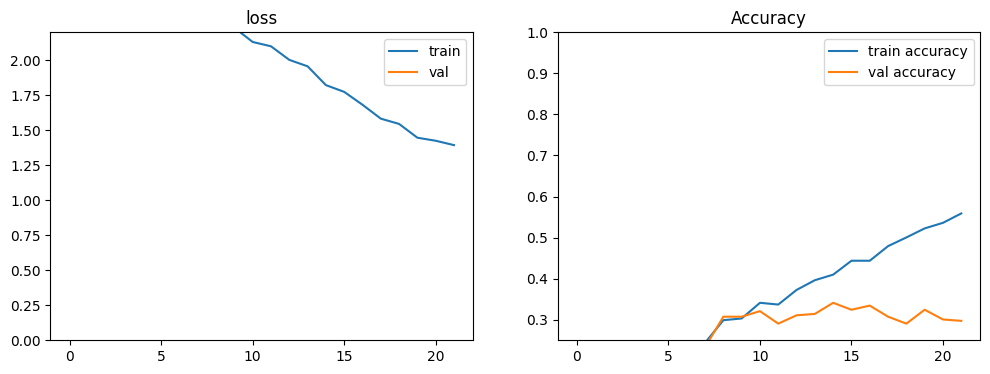

In [93]:
plot_history(history)